# Проект

В данном проекте мы пытаемся понять, стоит ли давать человеку кредит. Для этого мы будем предсказывать вероятность того, что он не вернёт деньги.

## Список признаков

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отклонённых в прошлом заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту (наша __целевая переменная__)

## Импорт библиотек, загрузка датасета, первичный анализ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.metrics import roc_auc_score, roc_curve, f1_score,\
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# для подбора гиперпараметров будем использовать "successive halving", он эффективней обычного GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import warnings
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
test.info()
# видим, что на целевая переменая известна только для трейна, а на тесте её (ожидаемо) надо будет предсказать

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [5]:
train["train"] = 1
test["train"] = 0
test["default"] = -1 # в тесте нет значений целевой переменной, поэтому пока просто заполняем константой
data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [6]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,train,default
30368,82457,30MAR2014,GRD,M,27,Y,N,0,0,-1.615399,0,40,2,3,30000,2,3,Y,0,-1
86563,79519,27MAR2014,UGR,M,27,N,N,0,0,-2.466187,1,60,1,2,22000,1,3,N,1,0
67889,86514,03APR2014,SCH,M,35,N,N,3,0,-1.949103,0,40,1,3,50000,3,1,Y,1,0
10134,67590,16MAR2014,SCH,F,36,N,N,0,1,-1.736014,4,60,2,3,15000,1,3,N,0,-1
85472,51657,28FEB2014,UGR,F,39,Y,Y,0,1,-1.902977,5,70,1,3,65000,1,4,N,1,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
non_default = train["default"].value_counts()[0] # посмотрим на распределение целевой переменной
ratio = non_default / (train.shape[0] - non_default)
print(f"Соотношение классов: {ratio:.1f}\nПроцент недефолтных клиентов: {100 * non_default / train.shape[0]:.1f}")
# видим, что выборка несбалансирована: "хороших" клиентов почти в семь раз больше, чем "плохих"
# значит последних будет труднее определить

Соотношение классов: 6.9
Процент недефолтных клиентов: 87.3


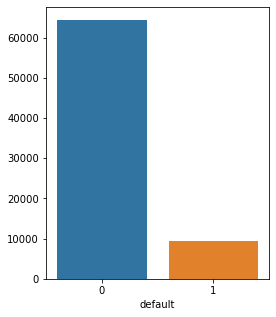

In [9]:
plt.figure(figsize=(4, 5))
ax = sns.countplot(x=train["default"])
ax.set(ylabel="");

## Некоторые функции

In [10]:
def borders(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return low, high

In [11]:
def check_outliers(col, data):
    """
    Определяет наличие выбросов в признаке col датасета data методом интерквантильного размаха 
    """
    
    low, high = borders(data[col])
    outliers = ((data[col] < low) | (data[col] > high)).sum()
    
    if not outliers:
        print(f"В признаке '{col}' выбросов нет\n")
        return

    print(f"Количество выбросов в признаке '{col}': {outliers}")
    print(f"Границы выбросов: [{low}, {high}]\n")

In [12]:
# modified function from https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6
def features_to_drop(df, cut):
    """
    На основании коэффицентов корреляции определяет признаки, которые стоит удалить
    
    df - датафрейм
    cut - пороговое значение коэффициента корреляции
    """

    corr_mtx = df.corr() # создаём корреляционную матрицу
    avg_corr = corr_mtx.mean(axis=1) # считаем среднюю корреляцию по признакам, это будет критерием отбора признаков
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(bool)) 
    # создаём верхний треугольник матрицы 
    # нижний не несёт дополнительной информации, так как матрица корреляций симметрична

    drop = [] # будущий список признаков для удаления

    for row in range(len(up)-1): # проходимся по всем строкам матрицы
        for col in range(row + 1, len(up)): # проходимся по всем столбцам
            if(abs(corr_mtx.iloc[row, col]) > cut):
                # если корреляция двух текущих признаков больше пороговой,
                # то удалим один из них (тот, у которого средняя корреляция больше)
                if(abs(avg_corr.iloc[row]) > abs(avg_corr.iloc[col])):
                    drop.append(row)
                else:
                    drop.append(col)
                
    dropcols_names = list(df.columns[list(set(drop))])
    if dropcols_names:
        return dropcols_names
    print("Сильноскоррелированных переменных нет")

In [13]:
def calc_f_score(y_true, y_pred):
    """
    считает наибольший f_score при различных порогах отнесения к нулевому и первому классам
    """
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    denom = precision + recall 
    denom[denom == 0] = -1
    # если знаменатель f-score равен нулю, то превратим его в -1 (так мы будем отличать этот случай)
    f_score = (2 * precision * recall / denom)[:-1] 
    return f_score, threshold

## Работа с пропусками

In [14]:
data.isna().sum()
# пропуски есть только в данных об образовании

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
train                 0
default               0
dtype: int64

In [15]:
data["education"].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [16]:
data["education"].fillna(data["education"].mode()[0], inplace=True)
data.isna().sum().sum()

0

## Работа с переменными

### 1.  Числовые признаки
* client_id - идентификатор
* age - возраст
* decline_app_cnt - количество отклонённых заявок
* score_bki - скоринговый балл
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* income - доход

In [17]:
data["client_id"].nunique() == data.shape[0]
# Видим, что id уникален для каждого клиента, поэтому его можно удалить

True

In [18]:
data.drop("client_id", axis=1, inplace=True)

In [19]:
num_cols = ["age", "decline_app_cnt", "score_bki", 
            "bki_request_cnt", "region_rating", "income"]

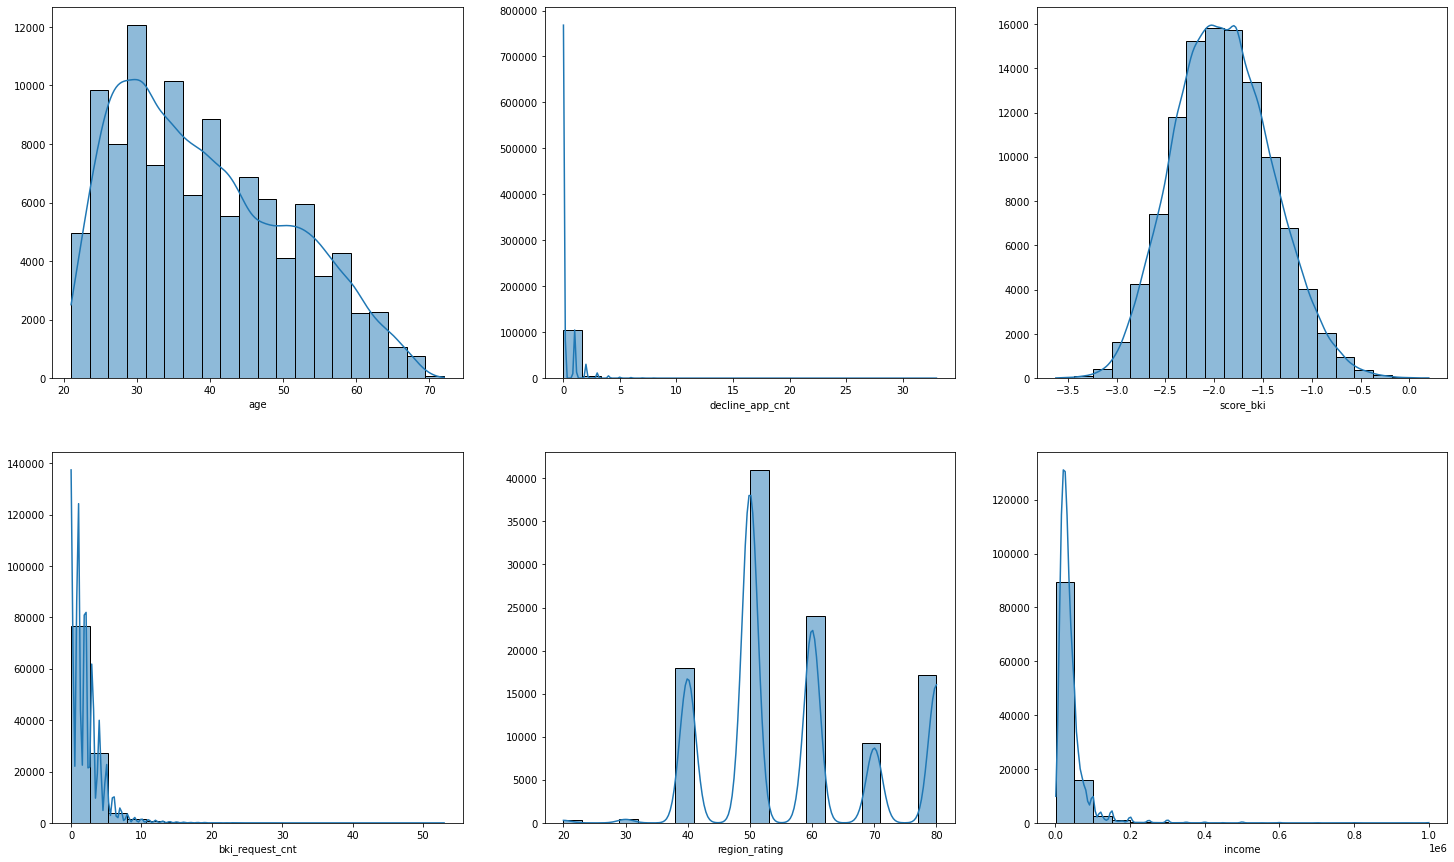

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i, col in enumerate(num_cols):
    hist = sns.histplot(data[col], bins=20, kde=True, ax=axes.flat[i])
    hist.set(ylabel="")

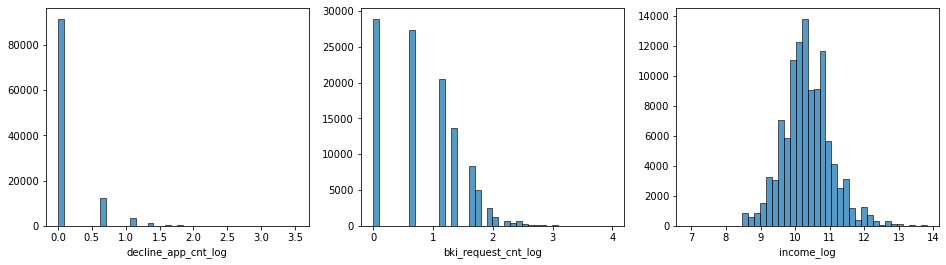

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(["decline_app_cnt", "bki_request_cnt", "income"]):
#     data[col] = np.log(data[col] + 1)
#     hist = sns.histplot(data[col], bins=40, ax=axes.flat[i], kde=False)
    num_cols.append(f"{col}_log")
    data[f"{col}_log"] = np.log(data[col] + 1)
    hist = sns.histplot(data[f"{col}_log"], bins=40, ax=axes.flat[i], kde=False)
    hist.set(ylabel="")

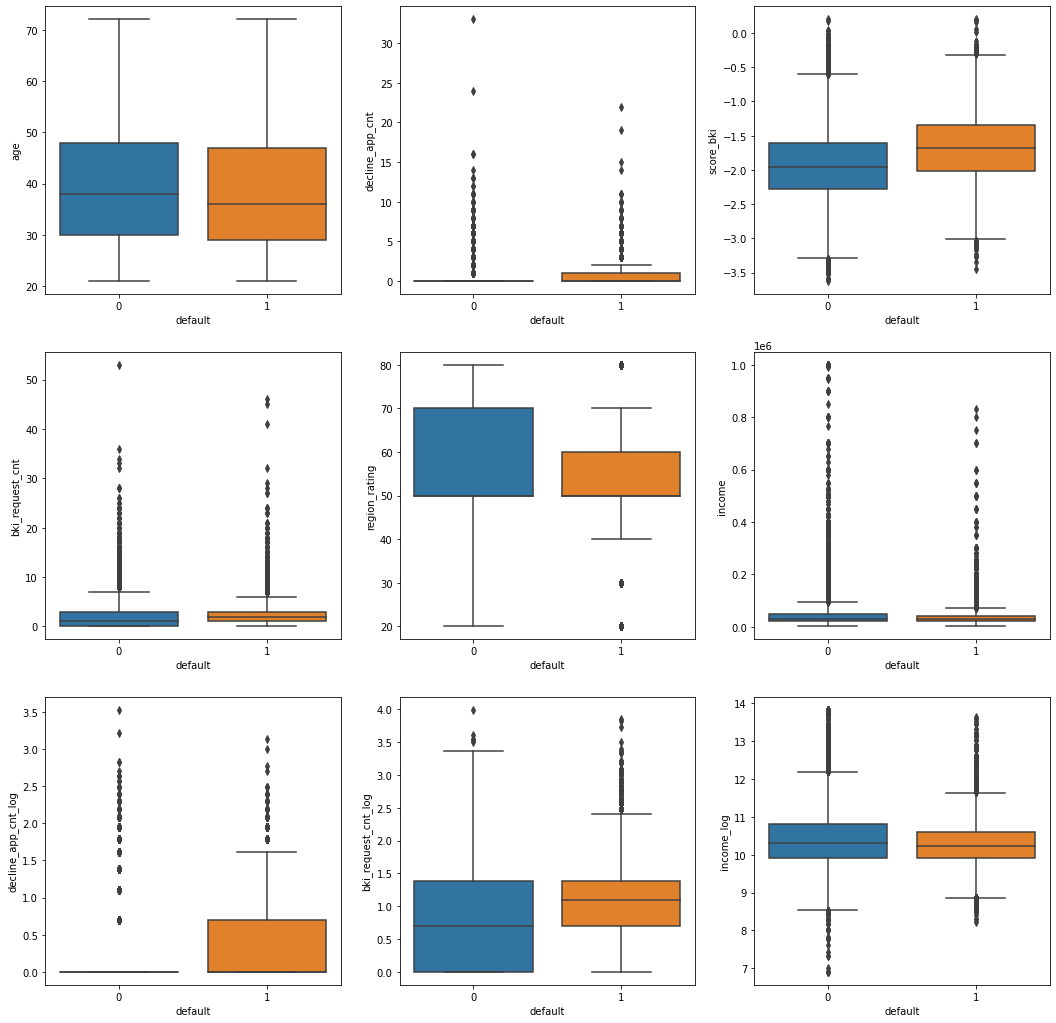

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data[data["default"]>=0], orient="v", ax=axes[i])
# видим, например, что у "хороших" клиентов в прошлом обычно не было отказов на выдачу кредитов
# также у них более низкий скоринговый балл и меньше запросов в БКИ

### Работа с выбросами
Классический подход определяет многие данные как выбросы. Попробуем понять, действительно ли это выбросы.

In [23]:
for col in num_cols:
    check_outliers(col, data)

В признаке 'age' выбросов нет

Количество выбросов в признаке 'decline_app_cnt': 18677
Границы выбросов: [0.0, 0.0]

Количество выбросов в признаке 'score_bki': 518
Границы выбросов: [-3.299251946250001, -0.5290698762499992]

Количество выбросов в признаке 'bki_request_cnt': 2636
Границы выбросов: [-4.5, 7.5]

Количество выбросов в признаке 'region_rating': 17917
Границы выбросов: [35.0, 75.0]

Количество выбросов в признаке 'income': 7000
Границы выбросов: [-22000.0, 90000.0]

Количество выбросов в признаке 'decline_app_cnt_log': 18677
Границы выбросов: [0.0, 0.0]

Количество выбросов в признаке 'bki_request_cnt_log': 15
Границы выбросов: [-2.0794415416798357, 3.465735902799726]

Количество выбросов в признаке 'income_log': 2609
Границы выбросов: [8.590378193705899, 12.092136480586621]



__decline_app_cnt__

In [24]:
dac = data["decline_app_cnt"]
dac.mean(), dac.max()
# максимальное значение признака в сто раз больше среднего

(0.2732051421723499, 33)

In [25]:
borders(dac)

(0.0, 0.0)

In [26]:
dac.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

Стандартный подход говорит нам, что в этом признаке всё, кроме нулей - выбросы. Если мы заменим всё на нули, то признак потеряет какую-либо ценность для модели. Потому подойдём к выбросам умнее, сделав из этого признака бинарный (у нас также останется логарифмированный вариант признака): 0 - не было отказов, 1 - были.

In [27]:
dac[dac >= 1] = 1
num_cols.remove("decline_app_cnt")

In [28]:
data["decline_app_cnt"].value_counts()
# заметим, что мы изменили исходные данные (как и хотели)

0    91471
1    18677
Name: decline_app_cnt, dtype: int64

### 2.  Бинарные признаки
* sex - пол клиента
* car - флаг наличия машины
* car_type - флаг машины-иномарки
* good_work - флаг наличия "хорошей" работы
* foreign_passport - флаг наличия иностранного паспорта

In [29]:
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] 
# целевая переменная "default" и изменённая "decline_app_cnt" также являются бинарными

In [30]:
for col in bin_cols:
    print(data[col].value_counts())

F    61836
M    48312
Name: sex, dtype: int64
N    74290
Y    35858
Name: car, dtype: int64
N    89140
Y    21008
Name: car_type, dtype: int64
0    91917
1    18231
Name: good_work, dtype: int64
N    93721
Y    16427
Name: foreign_passport, dtype: int64


In [31]:
enc = LabelEncoder()
for col in bin_cols:
    data[col] = enc.fit_transform(data[col])

### 3.  Категориальные признаки
* education - уровень образования
* home_address - категория домашнего адреса
* work_address - категория рабочего адреса
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о клиенте

In [32]:
cat_cols = ["education", "home_address", "work_address", "sna",  "first_time"]

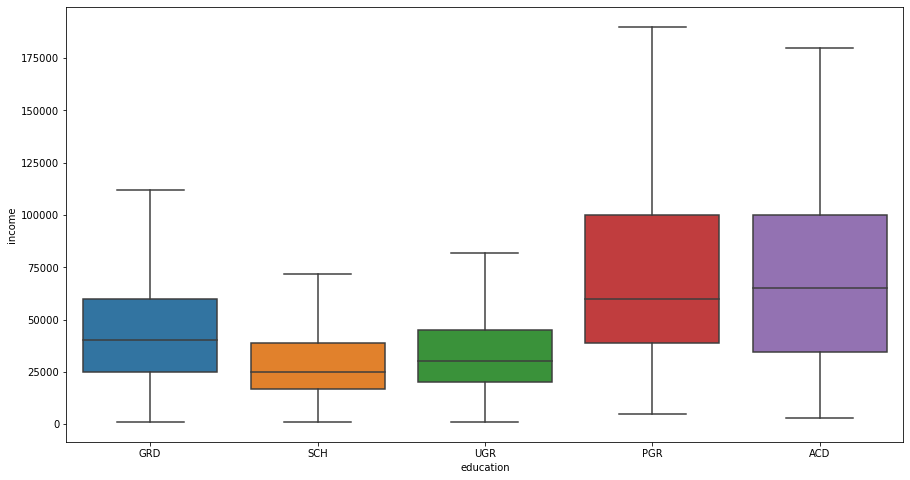

In [33]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False);
# посмотрим, влияет ли уровень образования на доход

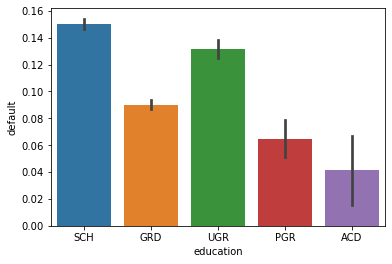

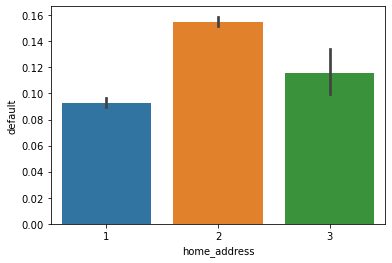

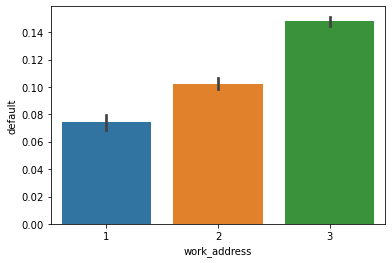

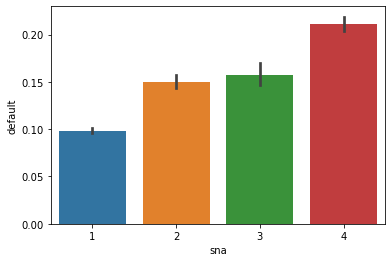

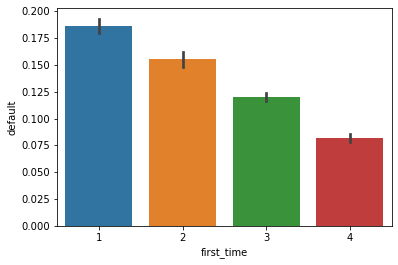

In [34]:
for col in cat_cols:
    sns.barplot(x=col, y="default", data=data[data["default"] >= 0])
    plt.show();
# видим, что клиенты с высшим образованием в среднем надёжнее
# а признаки work_address, sna и first_time можно расссматривать как "ординальные"

In [35]:
# поменяем классы 2 и 3 для признака home_address, чтобы исправить тренд
def swap(x):
    if x == 2:
        return 3
    if x == 3:
        return 2
    return x

data["home_address"] = data["home_address"].apply(swap)

In [36]:
data["has_degree"] = data["education"].apply(lambda x: 1 if x in ["PGR", "ACD"] else 0)
bin_cols.append("has_degree")

In [37]:
# data["education"] = enc.fit_transform(data["education"])
# закодируем также данные об образовании - это корректно, так как переменная ординальная
ed = pd.crosstab(data[data.default >= 0].education, data[data.default >= 0].default, normalize='index').iloc[:, 1]
data.education = data.education.map(ed)

In [38]:
new = pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(data[cat_cols].values)).astype(int)
data = pd.concat([data.drop(cat_cols, axis=1), new], axis=1)
# data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
# закодируем категориальные переменные

__app_date__

In [39]:
data["app_date"]
# дата в неудобном формате, преобразуем её

0         22MAR2014
1         24JAN2014
2         23MAR2014
3         03FEB2014
4         04FEB2014
            ...    
110143    04MAR2014
110144    24MAR2014
110145    22APR2014
110146    04JAN2014
110147    23JAN2014
Name: app_date, Length: 110148, dtype: object

In [40]:
data["app_date"] = data["app_date"].apply(lambda x: datetime.strptime(x, '%d%b%Y').timestamp()).astype(int)

## Feature engineering

In [41]:
data["bki_age_region"] = data["score_bki"] * data["region_rating"] / data["age"]

In [42]:
mean_income = data.groupby("age")["income"].mean().to_dict()
data["mean_income"] = data["age"].map(mean_income)

In [43]:
max_income = data.groupby("age")["income"].max().to_dict()
data["max_income"] = data["age"].map(max_income)

In [44]:
data["normalized_income"] = abs(data.income - data.mean_income) / data.max_income

In [45]:
mean_income_reg = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_reg)

In [46]:
mean_bki_age = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki_age)

In [47]:
mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc)

In [48]:
num_cols = ["age", "decline_app_cnt", "score_bki", 
            "bki_request_cnt", "region_rating", "income", 
            "app_date", "bki_age_region", "mean_income",
            "max_income", "normalized_income", "mean_income_region",
            "mean_requests_age", "mean_requests_income"]
# обновим список численных переменных

In [49]:
# отнормируем признаки
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns=num_cols)

## Корреляционная матрица

In [50]:
corr = data.drop("train", axis=1).corr()
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)) 
for i in up.index:
    for col in up.columns:
        if i != col and abs(up.loc[i, col]) > 0.7:
                print(f"Признаки {i} и {col} имеют корреляцию {up.loc[i, col]:.3f}")
# видим, что высоко скоррелированы модифицированные признаки и их изначальные версии, а также home_address и work_address

Признаки decline_app_cnt и decline_app_cnt_log имеют корреляцию 0.927
Признаки bki_request_cnt и bki_request_cnt_log имеют корреляцию 0.895
Признаки region_rating и mean_income_region имеют корреляцию 0.917
Признаки income и income_log имеют корреляцию 0.778
Признаки income и normalized_income имеют корреляцию 0.800
Признаки has_degree и 1 имеют корреляцию 0.929
Признаки 2 и 4 имеют корреляцию -0.722
Признаки 5 и 7 имеют корреляцию -0.966
Признаки 5 и 10 имеют корреляцию -0.820
Признаки 7 и 10 имеют корреляцию 0.795
Признаки 9 и 10 имеют корреляцию -0.777


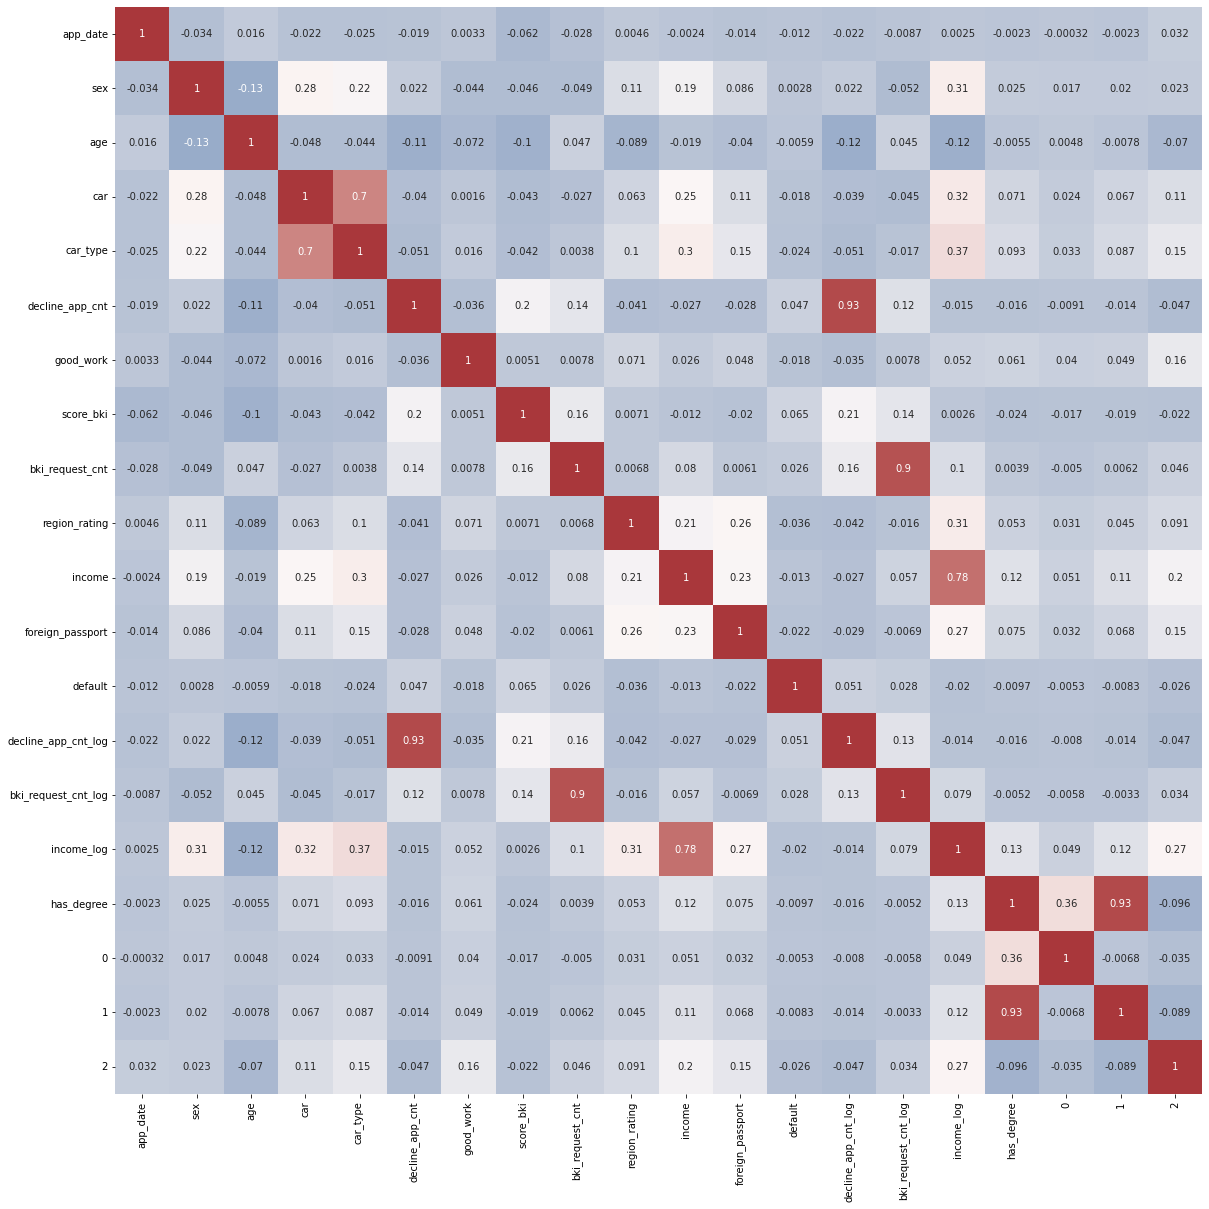

In [51]:
plt.rcParams['figure.figsize'] = 20, 20
sns.heatmap(corr.iloc[:20, :20], cmap='vlag', annot=True, vmin = -0.5, cbar=False, square=True); 

In [52]:
determinant = np.prod(np.linalg.eig(data.corr())[0])
print(f"Determinant of the matrix is {determinant:.100f}")
# детерминант маленький, и это не радует

Determinant of the matrix is 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000818281607


In [53]:
drop = features_to_drop(data.drop("train", axis=1), cut=.9)
# найдём признаки, скоррелированные сильнее 0.9 по модулю
drop

['mean_income_region', 'has_degree', 'decline_app_cnt_log', 5]

In [54]:
data.drop(drop, axis=1, inplace=True)

In [55]:
determinant = np.prod(np.linalg.eig(data.corr())[0])
print(f"Determinant of the matrix is {determinant:.100f}")
# стало чуть лучше :,)

Determinant of the matrix is 0.0000000000000000000000000000000000000000000000000000000000000199802684937326348566518023685248360756


## Подготовка данных и обучение модели

In [56]:
train_df = data.query("train == 1").drop(["train"], axis=1)
test_df = data.query("train == 0").drop(["train", "default"], axis=1)

In [57]:
X = train_df.drop(["default"], axis=1).values
y = train_df["default"].values

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=100)

In [59]:
lr = LogisticRegression(max_iter=1000, random_state=497186)

In [60]:
lr.fit(X_train, y_train)
probs = lr.predict_proba(X_valid)[:, 1]

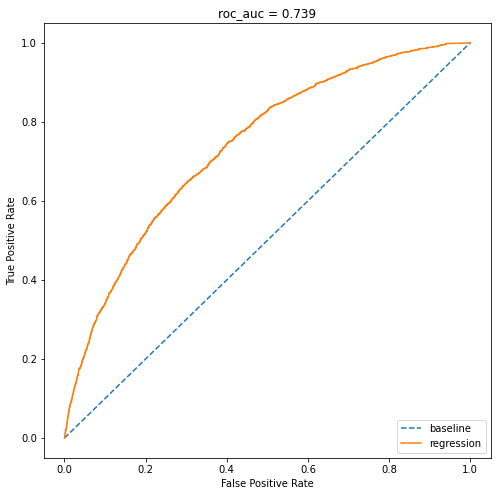

In [61]:
plt.rcParams["figure.figsize"] = 8, 8
fpr, tpr, _ = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)
plt.plot([0, 1], label="baseline", linestyle="--")
plt.plot(fpr, tpr, label="regression")
plt.title(f"roc_auc = {roc_auc:0.3f}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right");

In [62]:
pred = lr.predict(X_valid)
f1_score(pred, y_valid)
# очень низкий f-score, посмотрим матрицу ошибок

0.05893909626719057

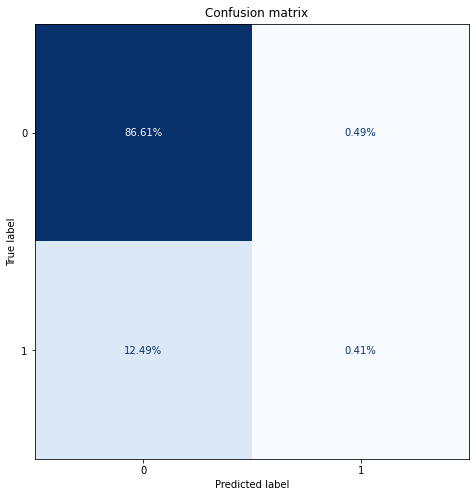

In [63]:
cm = confusion_matrix(y_valid, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/np.sum(cm), display_labels=lr.classes_) # или confusion_matrix=cm
disp.plot(cmap="Blues", colorbar=False, values_format=".2%") # или values_format=".0f"
plt.suptitle("Confusion matrix", x=.52, y=.91);
# всё понятно, модель считает >99% клиентов надёжными

In [64]:
f_score, thresholds = calc_f_score(y_valid, probs)
best_f_score = max(f_score)
threshold = thresholds[np.argmax(f_score)]
print(f"threshold = {threshold}\nbest_f_score = {best_f_score}")

threshold = 0.1690253736795258
best_f_score = 0.3648985404058384


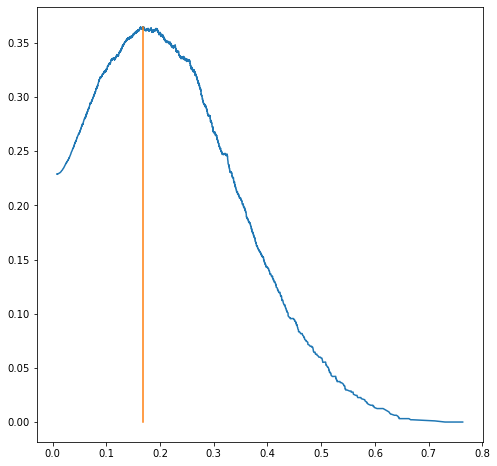

In [65]:
plt.plot(thresholds, f_score)
plt.plot(np.array([threshold] * 1000), np.linspace(0, best_f_score, 1000));

In [66]:
probs[probs >= threshold] = 1
probs[probs < threshold] = 0

Порог дефолта выбрали сильно меньше 0.5, иначе получалось, что одобряли кредиты всем. Да, мы отсекаем больше "хороших" клиентов, но зато меньше ошибаемся в "плохих". Такой порог позволяет максимизировать f_score на тестовых данных, однако не гарантирует, что и на новых метрика тоже будет максимальной. Посмотрим на матрицу ошибок ещё раз.

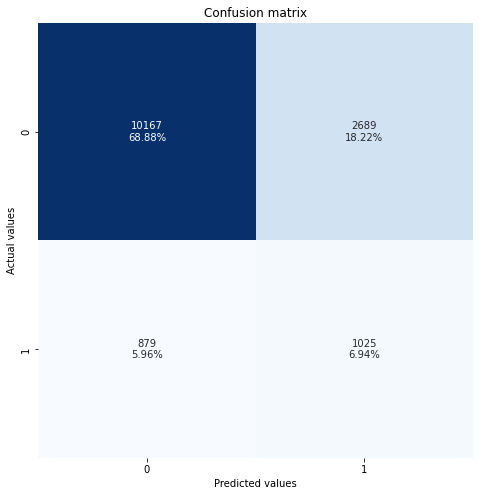

In [67]:
cm = confusion_matrix(y_valid, probs)
X = [str(i) for i in cm.flatten()]
Y = [f"{i:.2%}" for i in cm.flatten() / np.sum(cm)]
labels = np.asarray([x+"\n"+y for x, y in zip(X, Y)]).reshape(2, -1)
ax = sns.heatmap(cm, annot=labels, cbar=False, fmt='', cmap='Blues', square=True)
ax.set_title("Confusion matrix")
ax.set_xlabel("Predicted values")
ax.set_ylabel("Actual values");
# мы понизили порог дефолта и теперь вычисляем половину "плохих" клиентов (однако теряем и хороших)

In [68]:
# y_pred = lr.predict_proba(test_df)[:, 1]
# y_pred[y_pred >= threshold] = 1
# y_pred[y_pred < threshold] = 0 
# result = pd.DataFrame(data={'client_id': test['client_id'], 'default': y_pred}).astype(int)
# result.to_csv('submission.csv', index=False) # здесь был первый submission

## Подбор гиперпараметров

Нас интересуют следующие гиперпараметры класса LogisticRegression из библиотеки sklearn:
* penalty: тип регуляризации
* C: обратная сила регуляризации
* solver: алгоритм решения задачи оптимизации (различные алгоритмы совместимы с разными penalty)
* tol: чувствительность критерия остановки

In [69]:
lr = LogisticRegression(warm_start=True, random_state=3193865169)
# warm_start=True сэкономит нам время при подборе гиперпараметров
# ввиду несбалансированости классов, зададим class_weight="balanced" (не помогло, поэтому убрал)

param_grid = [{"solver": ["newton-cg", "lbfgs", "sag", "saga", "liblinear"],
               # здесь будет использоваться penalty="l2" - оно стоит по умолчанию
              "tol": np.geomspace(10**-6, 10**-2, 5),
               "C": np.geomspace(10**-4, 10**4, 9)},
              {"solver": ["saga", "liblinear"],
               "penalty": ["l1"],
               "tol": np.geomspace(10**-6, 10**-2, 5),
               "C": np.geomspace(10**-4, 10**4, 13)},
              {"solver": ["newton-cg", "lbfgs", "sag"],
               "penalty": ["none"],
               "tol": np.geomspace(10**-6, 10**-2, 5)}]
# зададим сетку поиска гиперпараметров, учитывая, что различные алгоритмы совместимы с разными регуляризациями

In [70]:
searcher = HalvingGridSearchCV(estimator=lr, param_grid=param_grid, scoring="f1", 
                               min_resources="smallest", factor=2, cv=3, n_jobs=-1, random_state=6187)

### Внимание!  
Следующая ячейка может работать около минуты

In [71]:
start = datetime.now()
searcher.fit(X_train, y_train)
end = datetime.now()

In [72]:
print(end - start) # здесь печатаем время работы ячейки

0:00:06.668279


In [73]:
searcher.best_estimator_

LogisticRegression(penalty='none', random_state=3193865169, solver='sag',
                   tol=0.01, warm_start=True)

In [74]:
y_pred = searcher.predict(X_valid)
f1_score(y_pred, y_valid)

0.056240749876665025

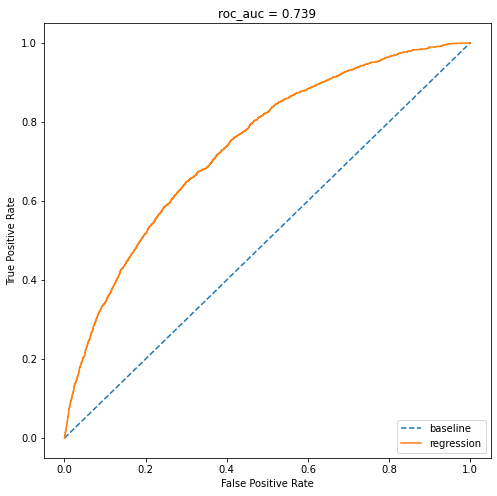

In [75]:
probs = searcher.predict_proba(X_valid)[:, 1]
plt.rcParams["figure.figsize"] = 8, 8
fpr, tpr, _ = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.plot([0, 1], label="baseline", linestyle="--")
plt.plot(fpr, tpr, label="regression")
plt.title(f"roc_auc = {roc_auc:0.3f}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right");

In [76]:
f_score, thresholds = calc_f_score(y_valid, probs)
best_f_score = max(f_score)
threshold = thresholds[np.argmax(f_score)]
print(f"threshold = {threshold:.5f}\nbest_f_score = {best_f_score:.5f}")

threshold = 0.16877
best_f_score = 0.36331


## Финальное предсказание  
Использование лишь подбора гиперпараметров не помогло добиться лучшего f_score. Лучшая метрика (0.35524) была достигнута с помощью подбора порогового значения дефолта (вручную написанная функция calc_f_score), просто же с помощью "лучшей", по мнению HalvingGridSearchCV, модели удалось получить метрику равную всего лишь 0.34343, что я рассматриваю как значительно более низкую.

In [77]:
y_pred = searcher.predict_proba(test_df)[:, 1]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0 
result = pd.DataFrame(data={'client_id': test['client_id'], 'default': y_pred}).astype(int)
result.to_csv('./submission.csv', index=False)

In [78]:
# y_pred = searcher.predict(test_df)
# result = pd.DataFrame(data={'client_id': test['client_id'], 'default': y_pred}).astype(int)
# result.to_csv('submission.csv', index=False)

## Что ещё? 

Возможно, следовало попробовать другие модели (вроде Catboost), однако данное соревнование в первую очередь направлено на знакомство логистической регрессией. Также я не попробовал under- и oversampling, не особо работал с выбросами, не анализировал важность признаков (за исключением метода корелляций). Вместо использования HalvingGridSearchCV можно было попробовать optuna. В целом результат получился хорошим для учебного проекта, я научился новому.